In [1]:
#import pandas
import pandas as pd

In [2]:
#read in csv file
df = pd.read_csv('big_data.csv')

In [3]:
#check data count, data types, columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           6807 non-null   int64  
 1   INJURY_BAD           6807 non-null   float64
 2   HELMET_USED          6807 non-null   float64
 3   age_bins             6807 non-null   object 
 4   SAFE_PEDAL_ACTION    6807 non-null   object 
 5   PROTECTIVE_CLOTHING  6807 non-null   float64
 6   SAFE_LOCATION        6807 non-null   float64
 7   WEATHER_CAT          6807 non-null   object 
 8   road_surf_bins       6807 non-null   object 
 9   DAYTIME              6807 non-null   int64  
 10  SPEED_RATING         6807 non-null   object 
 11  physical_bins        6807 non-null   object 
 12  hour_bins            6807 non-null   object 
 13  SEX                  6807 non-null   object 
dtypes: float64(4), int64(2), object(8)
memory usage: 744.6+ KB


In [4]:
#drop columns we won't use. first is unnecessary, second not significant, third is too similar to hour_bins
df = df.drop(['Unnamed: 0','road_surf_bins','DAYTIME'],axis=1)

In [5]:
#drop 3rd sex 'X', very small number in this sex category
df = df.loc[df['SEX'] != 'X']

In [6]:
#drop 'Shaken' category in driver physical condition, which is too influenced by 'Taken to EMS'.
#Tells us less about driver at time of crash and more about driver after the crash (less cause, more result).
#Of course more likely to have a bad crash if the driver also needed to be hospitalized.
df = df.loc[df['physical_bins'] != 'Shaken']

In [7]:
#check to see if 'X' was dropped from sex column
df['SEX'].value_counts()

M    5202
F    1369
Name: SEX, dtype: int64

In [8]:
#check to see all changes were made correctly and how many values were dropped as a result.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6571 entries, 0 to 6806
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   INJURY_BAD           6571 non-null   float64
 1   HELMET_USED          6571 non-null   float64
 2   age_bins             6571 non-null   object 
 3   SAFE_PEDAL_ACTION    6571 non-null   object 
 4   PROTECTIVE_CLOTHING  6571 non-null   float64
 5   SAFE_LOCATION        6571 non-null   float64
 6   WEATHER_CAT          6571 non-null   object 
 7   SPEED_RATING         6571 non-null   object 
 8   physical_bins        6571 non-null   object 
 9   hour_bins            6571 non-null   object 
 10  SEX                  6571 non-null   object 
dtypes: float64(4), object(7)
memory usage: 616.0+ KB


In [9]:
#import train test split and decision tree to first determine X variable feature importances
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [10]:
#create X and y variables, perform train test split
y = df['INJURY_BAD']
X = df.drop('INJURY_BAD',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=312)

In [11]:
#import one hot encoder
from sklearn.preprocessing import OneHotEncoder

In [12]:
#one hot encode X train and X test data sets
ohe = OneHotEncoder()
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

In [13]:
#import random undersampler and randomly undersample X_train majority class (non-severe injuries)
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(random_state=312)
X_u, y_u = under.fit_resample(X_train_encoded,y_train)

In [14]:
#instantiate decision tree classifier, fit it on train data that was one hot encoded and randomly undersampled
dt = DecisionTreeClassifier(max_depth=7,random_state=312)
dt.fit(X_u,y_u)

DecisionTreeClassifier(max_depth=7, random_state=312)

In [15]:
#import precision and recall scores. Evaluate train and test precision and recall scores
from sklearn.metrics import precision_score,recall_score

y_train_pred = dt.predict(X_u)
y_test_pred = dt.predict(X_test_encoded)

train_p = precision_score(y_u,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_u,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

Train Precision: 0.6987704918032787
Test Precision: 0.1173780487804878
Train Recall: 0.682
Test Recall: 0.5460992907801419


In [16]:
#import cross validation score. Evaluate decision tree model recall performance with default 5 folds on training set
from sklearn.model_selection import cross_val_score

recall = cross_val_score(dt,X_u,y_u,scoring='recall')
recall

array([0.54, 0.44, 0.38, 0.49, 0.52])

In [17]:
#look at mean recall score from cross validation
recall.mean()

0.47400000000000003

In [18]:
#evaluate model using precision cross validation as well (though primarily focused on recall)
precision = cross_val_score(dt,X_u,y_u,scoring='precision')
precision

array([0.55670103, 0.55696203, 0.54285714, 0.54444444, 0.53608247])

In [19]:
#look at mean precision score from cross validation
precision.mean()

0.5474094235545364

In [20]:
#run a grid search for best max depth parameter on decision tree model to maximize recall
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': range(1,30)}

grid_search = GridSearchCV(dt, param_grid, cv=5,scoring='recall')
grid_search.fit(X_u, y_u)

#Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

{'max_depth': 7}

In [21]:
#look at recall score for decision tree model with best max depth (of 7)
best_score

0.47400000000000003

In [22]:
#get feature importances, save as a list
importances = list(dt.feature_importances_)

In [23]:
#turn X variables used into a dataframe with column labels
xu_df = pd.DataFrame(X_u.todense(),columns=ohe.get_feature_names())

In [24]:
#turn the X variable columns names into a list
names = list(xu_df.columns)

In [25]:
#zip the two lists into a dictionary of column names and feature importances
importance_names = dict(zip(names,importances))

In [26]:
#look to see which columns had the highest feature importances
importance_names

{'x0_0.0': 0.03783275124411903,
 'x0_1.0': 0.025052116799617278,
 'x1_Adolescent': 0.027740590782442277,
 'x1_Adult': 0.062187160869183626,
 'x1_Elderly': 0.008650461649008992,
 'x1_Middle-aged': 0.0,
 'x2_Neutral': 0.021526311450192154,
 'x2_Safe': 0.08214362508442999,
 'x2_Unsafe': 0.049880413957519285,
 'x3_0.0': 0.06042514599040034,
 'x3_1.0': 0.008650461649008992,
 'x4_0.0': 0.06792879833927169,
 'x4_1.0': 0.03197415524575112,
 'x5_Adverse Weather': 0.05472446809861167,
 'x5_Clear Weather': 0.01834081405009036,
 'x6_Above Average Speed': 0.049143600386040376,
 'x6_Average Speed': 0.030187609535017035,
 'x6_Below Average Speed': 0.05199753462391583,
 'x7_Impaired': 0.0,
 'x7_Normal': 0.10078439341508483,
 'x7_Other': 0.0,
 'x8_Afternoon': 0.04644363464251603,
 'x8_Early Morning': 0.010455311054789826,
 'x8_Morning': 0.011218559769133957,
 'x8_Night': 0.060871814477444754,
 'x9_F': 0.058667298395674944,
 'x9_M': 0.02317296849073565}

In [27]:
#import logistic regression and minmaxscaler packages
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [28]:
#turn one hot encoded datasets back into data frames
X_train_df = pd.DataFrame(X_train_encoded.todense(),columns=ohe.get_feature_names())
X_test_df = pd.DataFrame(X_test_encoded.todense(),columns=ohe.get_feature_names())

In [29]:
#check to see if dataframe was correctly made
X_train_df

,x0_0.0,x0_1.0,x1_Adolescent,x1_Adult,x1_Elderly,x1_Middle-aged,x2_Neutral,x2_Safe,x2_Unsafe,x3_0.0,...,x6_Below Average Speed,x7_Impaired,x7_Normal,x7_Other,x8_Afternoon,x8_Early Morning,x8_Morning,x8_Night,x9_F,x9_M
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5251,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5252,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5253,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5254,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [30]:
#use only most important X variable physical condition (based on decision tree feature importance)
#scale train and test data
#run simple logistic regression, fit on train data
#calculate precision and recall scores for train and test sets
scaler = MinMaxScaler()
X_train_simple = X_train_df.iloc[:,-9:-6]
X_test_simple = X_test_df.iloc[:,-9:-6]
X_train_simple_scaled = scaler.fit_transform(X_train_simple)
X_test_simple_scaled = scaler.transform(X_test_simple)

log_model_simple = LogisticRegression(class_weight='balanced',random_state=312)

log_model_simple.fit(X_train_simple_scaled,y_train)

y_train_pred = log_model_simple.predict(X_train_simple_scaled)
y_test_pred = log_model_simple.predict(X_test_simple_scaled)

train_p = precision_score(y_train,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_train,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

Train Precision: 0.15816326530612246
Test Precision: 0.18633540372670807
Train Recall: 0.186
Test Recall: 0.2127659574468085


In [31]:
#scale data for all X variables
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

In [32]:
#instantiate multiple X variables logistic regression model
log_model = LogisticRegression(class_weight='balanced',random_state=312)

In [33]:
#fit on train set
log_model.fit(X_train_scaled,y_train)

LogisticRegression(class_weight='balanced', random_state=312)

In [34]:
#calculate precision and recall scores for train and test sets
y_train_pred = log_model.predict(X_train_scaled)
y_test_pred = log_model.predict(X_test_scaled)

train_p = precision_score(y_train,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_train,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')


Train Precision: 0.12791828793774318
Test Precision: 0.14583333333333334
Train Recall: 0.526
Test Recall: 0.5460992907801419


In [35]:
#run cross validation on train set for recall metric
recall = cross_val_score(log_model,X_train_scaled,y_train,scoring='recall')
recall

array([0.56, 0.43, 0.41, 0.53, 0.55])

In [36]:
#calculate recall mean
recall.mean()

0.496

In [37]:
#run cross valiation on train set for precision metric
precision = cross_val_score(log_model,X_train_scaled,y_train,scoring='precision')
precision

array([0.13238771, 0.11375661, 0.1025    , 0.12354312, 0.12249443])

In [38]:
#calculate precision mean
precision.mean()

0.11893637524535974

In [39]:
#create a dictionary with column names and logistic regression coefficients
coef_dict = {}
for coef, feat in zip(log_model.coef_[0,:],X_train_df.columns):
    coef_dict[feat] = coef
for i,v in coef_dict.items():
    coef_dict[i] = round(v,2)
coef_dict

{'x0_0.0': -0.04,
 'x0_1.0': 0.03,
 'x1_Adolescent': -0.09,
 'x1_Adult': -0.26,
 'x1_Elderly': 0.29,
 'x1_Middle-aged': 0.06,
 'x2_Neutral': 0.04,
 'x2_Safe': -0.18,
 'x2_Unsafe': 0.14,
 'x3_0.0': -0.01,
 'x3_1.0': 0.01,
 'x4_0.0': 0.11,
 'x4_1.0': -0.12,
 'x5_Adverse Weather': 0.09,
 'x5_Clear Weather': -0.1,
 'x6_Above Average Speed': 0.26,
 'x6_Average Speed': -0.08,
 'x6_Below Average Speed': -0.18,
 'x7_Impaired': 0.14,
 'x7_Normal': -0.36,
 'x7_Other': 0.23,
 'x8_Afternoon': -0.21,
 'x8_Early Morning': 0.2,
 'x8_Morning': -0.1,
 'x8_Night': 0.11,
 'x9_F': 0.08,
 'x9_M': -0.08}

In [40]:
#turn selected top five log odds coefficients into odds for easier interpretation in presentation
import numpy as np
selected_five = np.array([-0.36,0.29,0.26,0.2,-0.18])
np.exp(selected_five)

array([0.69767633, 1.33642749, 1.29693009, 1.22140276, 0.83527021])

In [41]:
#run grid search to tune logistic regression for best recall score
param_grid = {'max_iter': [100,200,500,1000],'C': [0.001, 0.01, 0.1,1],'class_weight':['balanced']}

grid_search = GridSearchCV(log_model, param_grid, cv=5,scoring='recall')
grid_search.fit(X_train_scaled, y_train)

#Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

{'C': 0.001, 'class_weight': 'balanced', 'max_iter': 100}

In [42]:
#look at best recall score with optimal parameters
best_score

0.502

In [43]:
#instantiate logistic regression model with optimal parameters
log_model_grid = LogisticRegression(C=.001,class_weight='balanced',max_iter=100,random_state=312)

In [44]:
#fit on train set
log_model_grid.fit(X_train_scaled,y_train)

LogisticRegression(C=0.001, class_weight='balanced', random_state=312)

In [45]:
#evaluate model by looking at precision and recall scores on train and test sets
y_train_pred = log_model_grid.predict(X_train_scaled)
y_test_pred = log_model_grid.predict(X_test_scaled)

train_p = precision_score(y_train,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_train,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')


Train Precision: 0.12210621879255561
Test Precision: 0.13296903460837886
Train Recall: 0.538
Test Recall: 0.5177304964539007


In [46]:
#grid search best score already looked at recall, but we use cross validation to look at precision score as well
precision = cross_val_score(log_model_grid,X_train_scaled,y_train,scoring='precision')
precision

array([0.12747253, 0.1002445 , 0.1026253 , 0.11637931, 0.12087912])

In [47]:
#calculate precision mean from 5 folds
precision.mean()

0.11352015116066752

In [48]:
#import random forest classifier, instantiate random forest model, and fit on train data
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500,max_depth=5,random_state=312)
clf.fit(X_u,y_u)

RandomForestClassifier(max_depth=5, n_estimators=500, random_state=312)

In [49]:
#evaluate model by looking at precision and recall scores on train and test sets
y_train_pred = clf.predict(X_u)
y_test_pred = clf.predict(X_test_encoded)

train_p = precision_score(y_u,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_u,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

Train Precision: 0.6751054852320675
Test Precision: 0.1343804537521815
Train Recall: 0.64
Test Recall: 0.5460992907801419


In [50]:
#run grid search to tune random forest for best recall score
param_grid = {'max_depth': range(2,10),'n_estimators': [100,200,300,400,500]}

grid_search = GridSearchCV(clf, param_grid, cv=5,scoring='recall')
grid_search.fit(X_u, y_u)

#Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

{'max_depth': 5, 'n_estimators': 500}

In [51]:
#look at best recall score with optimal parameters
best_score

0.5279999999999999

In [52]:
#grid search best score already looked at recall, but we use cross validation to look at precision score as well
precision = cross_val_score(clf,X_u,y_u,scoring='precision')
precision

array([0.59      , 0.62337662, 0.61428571, 0.56043956, 0.5625    ])

In [53]:
#calculate precision mean from 5 folds
precision.mean()

0.5901203796203797

In [54]:
#similar to decision tree, look to see which columns had the highest feature importances
importances = list(clf.feature_importances_)
names = list(xu_df.columns)
importance_names = dict(zip(names,importances))
importance_names

{'x0_0.0': 0.025397153454684105,
 'x0_1.0': 0.030802459313423812,
 'x1_Adolescent': 0.02338442111246625,
 'x1_Adult': 0.07663359814006672,
 'x1_Elderly': 0.05529485976585344,
 'x1_Middle-aged': 0.03759085227728753,
 'x2_Neutral': 0.026851381395796143,
 'x2_Safe': 0.03207821719511488,
 'x2_Unsafe': 0.047373731337727286,
 'x3_0.0': 0.02818312311834049,
 'x3_1.0': 0.026352647951092247,
 'x4_0.0': 0.053776355497075795,
 'x4_1.0': 0.05141328340963572,
 'x5_Adverse Weather': 0.022195261509765776,
 'x5_Clear Weather': 0.02199090772087557,
 'x6_Above Average Speed': 0.03433395492997533,
 'x6_Average Speed': 0.025165854999724596,
 'x6_Below Average Speed': 0.024355966332122846,
 'x7_Impaired': 0.020418045264655058,
 'x7_Normal': 0.09430085509256886,
 'x7_Other': 0.06165348860620456,
 'x8_Afternoon': 0.053157149121422255,
 'x8_Early Morning': 0.02337384461662752,
 'x8_Morning': 0.025489248739164447,
 'x8_Night': 0.04128665390406852,
 'x9_F': 0.01701105258968977,
 'x9_M': 0.02013563260457047}

In [55]:
#import precision recall curve and area under the curve metrics
from sklearn.metrics import precision_recall_curve, auc

y_score = log_model.decision_function(X_test_scaled)
precision,recall,thresholds = precision_recall_curve(y_test,y_score)
print('AUC: {}'.format(auc(recall, precision)))

AUC: 0.1390465956571374


In [67]:
#calculate junk classifier for precision recall curve, which is equal to positive share of train set
y_train.value_counts(normalize=True)

0.0    0.904871
1.0    0.095129
Name: INJURY_BAD, dtype: float64

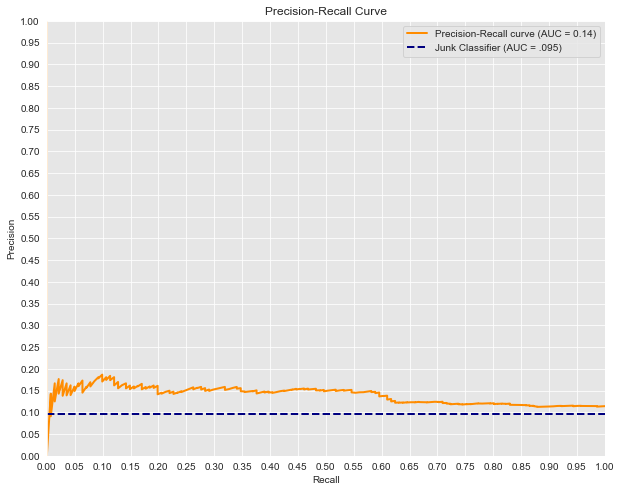

In [66]:
#chart precision recall curve for multi-variable logistic regression versus junk classifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Plot a Precision-Recall Curve
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='Precision-Recall curve (AUC = 0.14)')
plt.plot([0, 1], [0.0951, .0951], color='navy', lw=lw, linestyle='--',label='Junk Classifier (AUC = .095)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

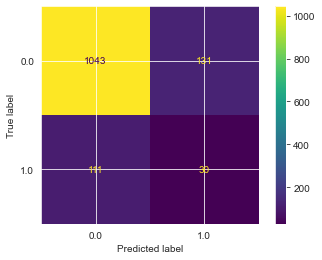

In [57]:
#import confusion matrix plot and plot confusion matrix for simple logistic regression
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(log_model_simple,X_test_simple_scaled,y_test);

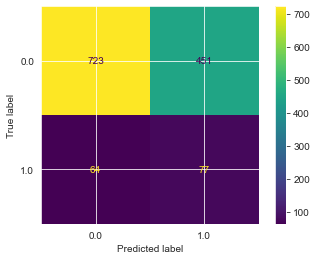

In [58]:
#plot confusion matrix for multiple X variables logistic regression
plot_confusion_matrix(log_model,X_test_scaled,y_test);

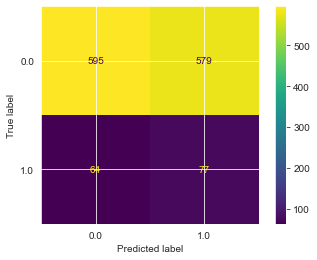

In [59]:
#plot confusion matrix for decision tree model
plot_confusion_matrix(dt,X_test_encoded,y_test);

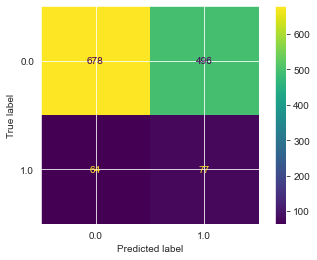

In [60]:
#plot confusion matrix for random forest model
plot_confusion_matrix(clf,X_test_encoded,y_test);